**Sudeshna Bora**

**AAND Numerical Assignment 04**

In [1]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

**1**

In [2]:
h1_data = sio.loadmat("c1p8.mat")
spikes = h1_data['rho'].flatten()
stimulus = h1_data['stim'].flatten()
spikes.shape

(600000,)

Given,

500 spikes in 1000 ms. 

Hence, 1 spike per ms . 

$\Delta t = 2$ 

Now,

20 minutes or 1200 seconds is the total duration. Additonally with 2ms resolution. So total length will be 

$\frac{20*60*1000}{2} = 600000$

We can also visualise it as 1 index represents a time of 2 ms.

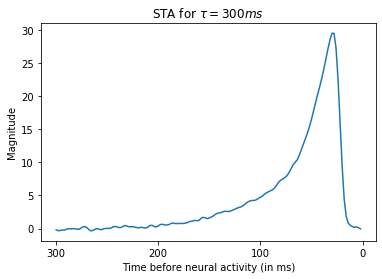

In [3]:
tau = 300
dt = 2               
num_timesteps = int(tau/dt)
sta = np.zeros(num_timesteps)           
    
indices = np.argwhere(spikes[:])        
indices = indices[indices>num_timesteps]
    
n = len(indices)
    
for index in indices:
    sta += stimulus[index-num_timesteps:index]
    
sta /= n

fig, ax1 = plt.subplots(1)
plt.plot(sta)
ax1.set_xticks([0, 50, 100, 150])
ax1.set_xticklabels(['300', '200', '100', '0'])
ax1.set_xlabel('Time before neural activity (in ms)')
ax1.set_title(r'STA for $\tau = 300 ms$')
ax1.set_ylabel('Magnitude')
plt.show()

As the STA is for only 1 trial, I believe we do not need an optimised convolution method as suggested by the right hand side formula.

**2**

We will use $\frac{spikeCount}{Trial length}$ for mean firing rate

In [4]:
T = 20*60*1000
dt = 2
mean_firing_rate = spikes.sum() / T
stimulus_variance = stimulus.var() * dt
D = mean_firing_rate * sta / stimulus_variance
print(mean_firing_rate)

0.0446675


**3**

In [5]:
r_est = np.convolve(D, stimulus, mode='same')
r_est -= r_est.mean()
r_est += mean_firing_rate
print(np.mean(r_est))

0.044667500000000006


In [6]:
def sliding_window_function(tau, delta): return 1 / \
    delta if tau >= -delta/2 and tau < delta/2 else 0

In [7]:
t = np.zeros(1000)
spike_slice = spikes[5000:6000]
spike_index = spike_slice.nonzero()

response = np.zeros(1000)
for t in range(len(response)):
    for spike_time in spike_index[0]:
        response[t] += sliding_window_function(t - spike_time, 20)
        

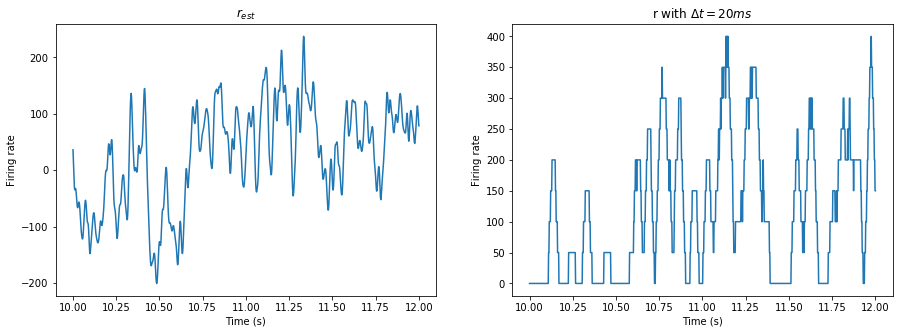

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax1)
plt.plot(np.linspace(10, 12, 1000), r_est[5000:6000]*1000)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate')
plt.title('$r_{est}$')

plt.sca(ax2)
plt.plot(np.linspace(10, 12, 1000), response*1000)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate')
plt.title('r with $\\Delta t = 20 ms$')
plt.show()

The $r_{0}$ that I chose was to center the $r_{est}$ to 0. This gave a $r_{est}$ to the $<r>$, so the linear kernel D is a good approximation. However, the glaring discrepancy that I notice is $r_{est}$ becomes negative. This is not observable in nature. This is the drawback of the Linear Kernel thus computed.

**4**

**4(a)** 

Taken help from Mehnous as facing issue with the timescales.

Taking max(r_est) as the estimated rate

In [9]:
n = 100000
maxRate = max(r_est)*1000
randNumbers2 = np.random.rand(n)
ISIs2 = -np.log(randNumbers2)/maxRate

SpikeTimes2 = np.cumsum(ISIs2)
randNumbers = np.random.rand(n)
Ps = r_est/maxRate
SpikeTimes_syn = SpikeTimes2[randNumbers>Ps[0:n]]
n = 10000
SpikeTimes_syn = SpikeTimes_syn[0:n]     # take just 10000 spikes

SpikeTimes_act = []
for index,value in enumerate(spikes):
    if value == 1:
        SpikeTimes_act.append(index*2/1000)
SpikeTimes_act = np.array(SpikeTimes_act)

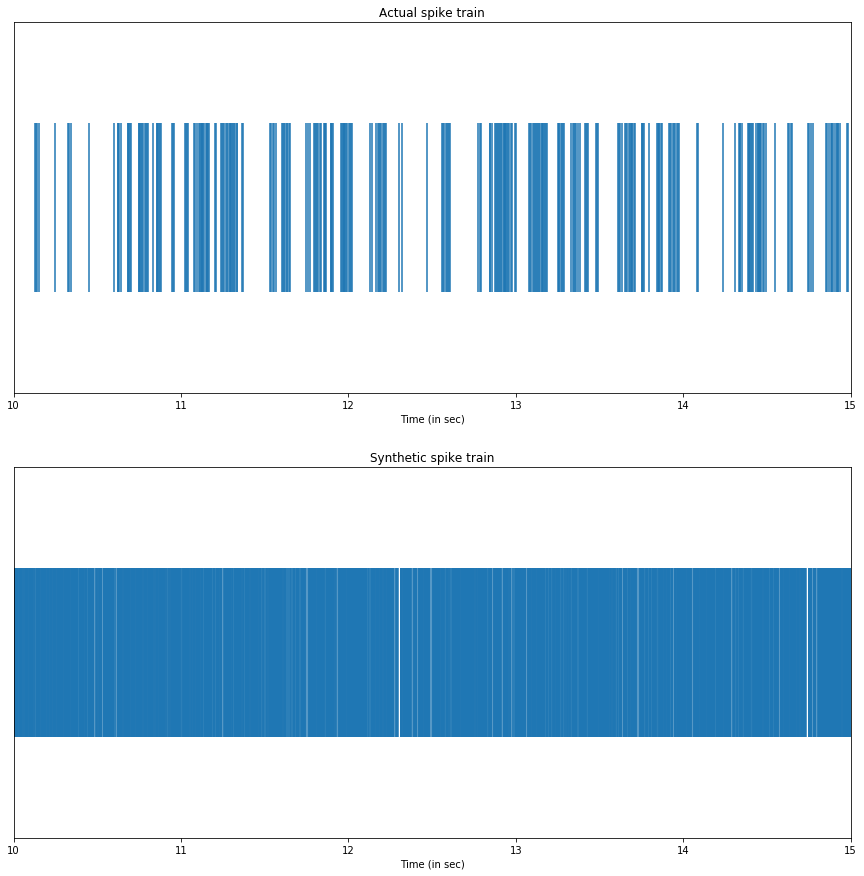

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

plt.sca(axs[0])
plt.eventplot(SpikeTimes_act)
plt.xlim(10,15)
plt.yticks([])
plt.xlabel('Time (in sec)')
plt.title('Actual spike train')


plt.sca(axs[1])
plt.eventplot(SpikeTimes_syn)
plt.xlim(10,15)
plt.yticks([])
plt.xlabel('Time (in sec)')
plt.title('Synthetic spike train')
plt.show()

**4 (b)**

In [11]:
ISI_act = np.diff(SpikeTimes_act)
ISI_syn = np.diff(SpikeTimes_syn)

In [12]:
print(ISI_act)
print(ISI_syn)

[0.01  0.006 0.012 ... 0.226 0.01  0.012]
[1.67074918e-04 1.02699305e-05 4.49725437e-03 ... 7.20877341e-04
 1.76314794e-03 1.47531404e-02]


In [13]:
ISI_act = ISI_act*100
ISI_syn = ISI_syn*1000

Text(0.5, 0.98, 'Histogram of ISI')

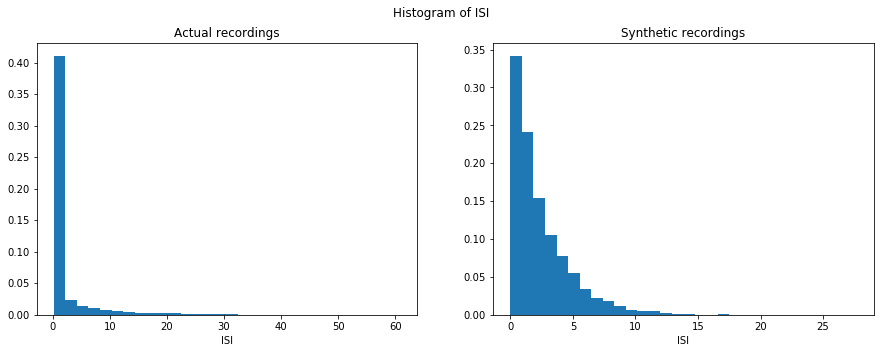

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axs[0])
plt.hist(ISI_act, 30, density=True)
plt.xlabel('ISI')
plt.title('Actual recordings')

plt.sca(axs[1])
plt.hist(ISI_syn, 30, density=True)
plt.xlabel('ISI')
plt.title('Synthetic recordings')

plt.suptitle('Histogram of ISI')

In [15]:
print('CV for actual recordings = {}'.format(np.std(ISI_act)/np.mean(ISI_act)))
print('CV for synthetic recordings  = {}'.format(np.std(ISI_syn)/np.mean(ISI_syn)))

CV for actual recordings = 2.008552337064105
CV for synthetic recordings  = 0.9908989313627227


**4(c)** 

In [16]:
def auto_correlation(SpikeTimes, n):
    ISI_dis = np.histogram(SpikeTimes, n)[0]
    return np.correlate(ISI_dis, ISI_dis, mode='same')

In [17]:
t = np.arange(-30, 30.1, 0.01)
n = t.shape[0]

autocorr_act = auto_correlation(SpikeTimes_act.flatten(), n)
autocorr_syn = auto_correlation(SpikeTimes_syn.flatten(), n)

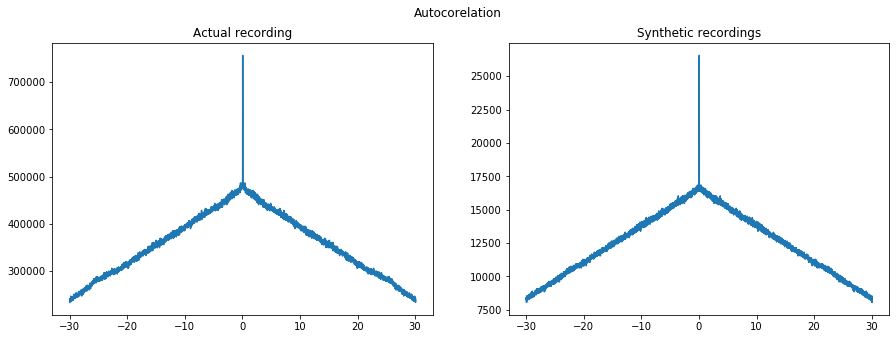

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axs[0])
plt.plot(t, autocorr_act)
plt.title('Actual recording')

plt.sca(axs[1])
plt.plot(t, autocorr_syn)
plt.title('Synthetic recordings')

plt.suptitle('Autocorelation')

plt.show()